In [1]:
import warnings

warnings.filterwarnings('ignore')

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import arviz as az
import bambi as bmb
import hddm_wfpt
import jax
import pytensor

In [6]:
import hssm

In [7]:
RNG = np.random.default_rng(seed=2025)
np.set_printoptions(suppress=True)

In [8]:
pytensor.config.floatX = "float32"
jax.config.update("jax_enable_x64", False)

## One-Level Model

In [9]:
true_params = {
    "v": 0.5,
    "a": 1.5,
    "z": 0.5,
    "t": 0.5
}

In [10]:
dataset = hssm.simulate_data(model="ddm", theta=true_params, size=1000)

In [11]:
dataset

,rt,response
0,2.824158,1.0
1,1.350275,1.0
2,0.750765,-1.0
3,2.717315,1.0
4,1.270280,1.0
...,...,...
995,1.696805,1.0
996,0.749250,-1.0
997,1.319521,1.0
998,2.075968,1.0


<Axes: xlabel='rt', ylabel='Count'>

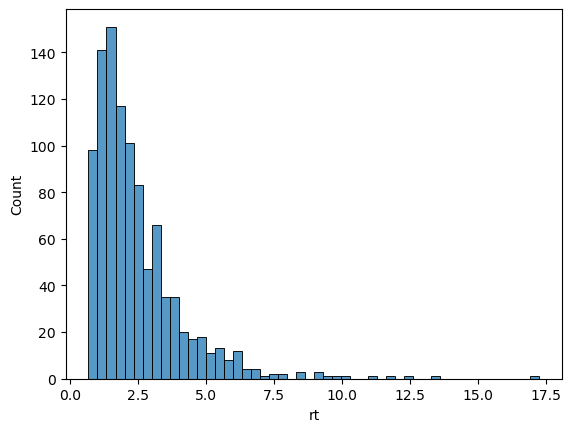

In [12]:
sns.histplot(dataset.rt)

In [13]:
simple_ddm = hssm.HSSM(data=dataset)

Model initialized successfully.


In [14]:
simple_ddm

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

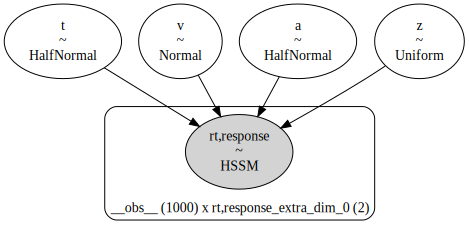

In [15]:
simple_ddm.graph()

In [16]:
simple_ddm_samples = simple_ddm.sample(
    sampler="mcmc",  # type of sampler to choose, 'nuts_numpyro',
    # 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=1000,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
    mp_ctx="spawn",
)

Using default initvals. 



Initializing NUTS using adapt_diag...
c:\envs\hssm-meta\lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [t, a, z, v]


c:\envs\hssm-meta\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 97 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
c:\envs\hssm-meta\lib\site-packages\pymc\pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:03<00:00, 316.25it/s]


In [17]:
simple_ddm_samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Diagnostics

In [18]:
az.summary(simple_ddm_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.498,0.022,0.456,0.538,0.001,0.001,507.0,469.0,1.01
v,0.583,0.035,0.518,0.646,0.001,0.001,724.0,768.0,1.00
z,0.476,0.013,0.451,0.500,0.001,0.000,550.0,481.0,1.00
a,1.477,0.029,1.427,1.532,0.001,0.001,648.0,530.0,1.00


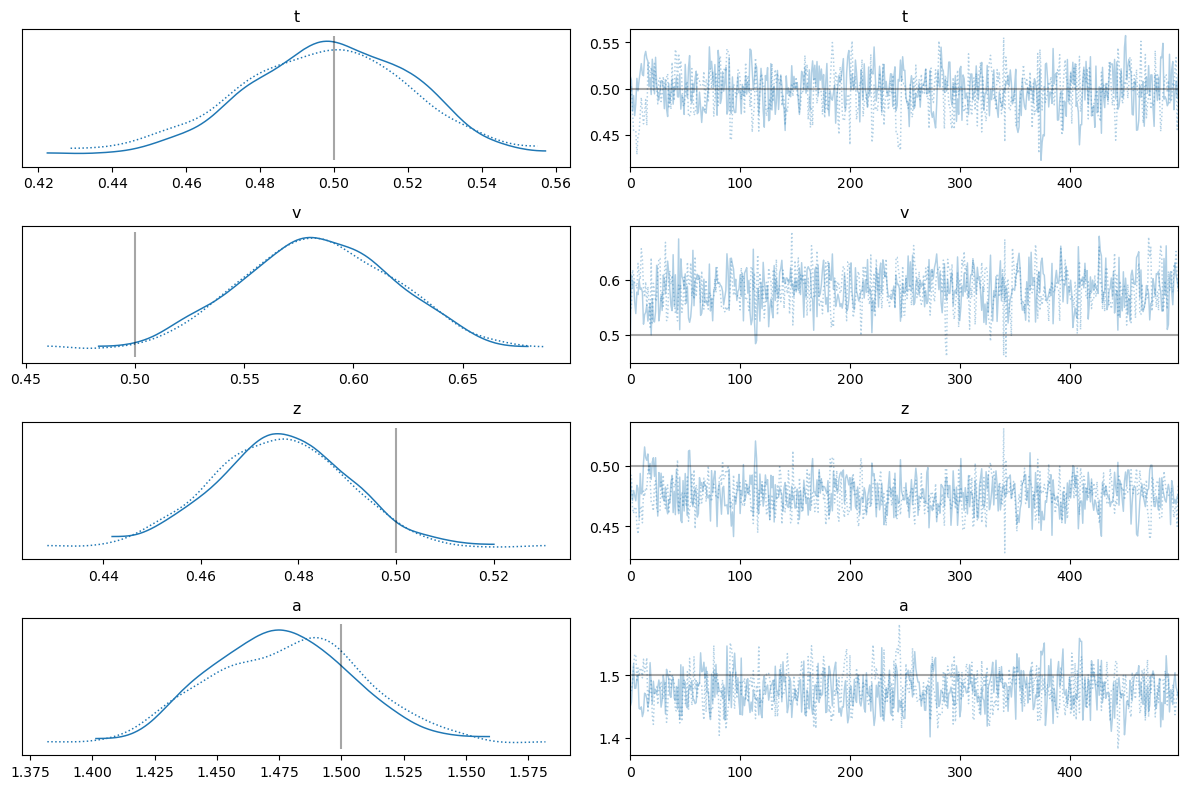

In [20]:
az.plot_trace(simple_ddm_samples, lines=[(key, {}, true_params[key]) for key in true_params],)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

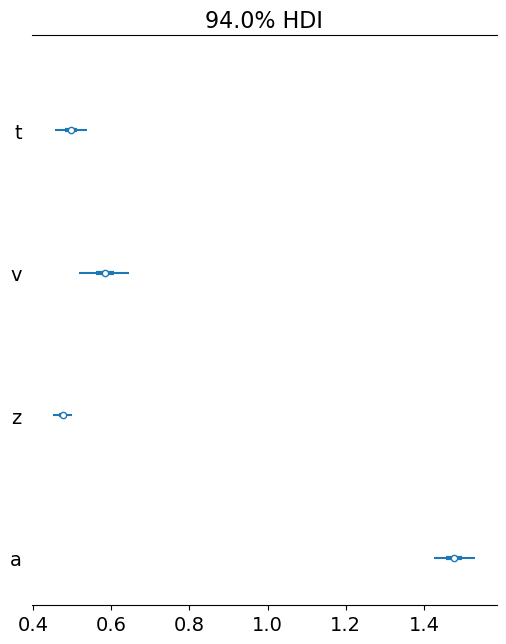

In [22]:
az.plot_forest(simple_ddm.traces, combined=True)

array([[<Axes: ylabel='t'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='z'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='t', ylabel='a'>, <Axes: xlabel='v'>,
        <Axes: xlabel='z'>, <Axes: xlabel='a'>]], dtype=object)

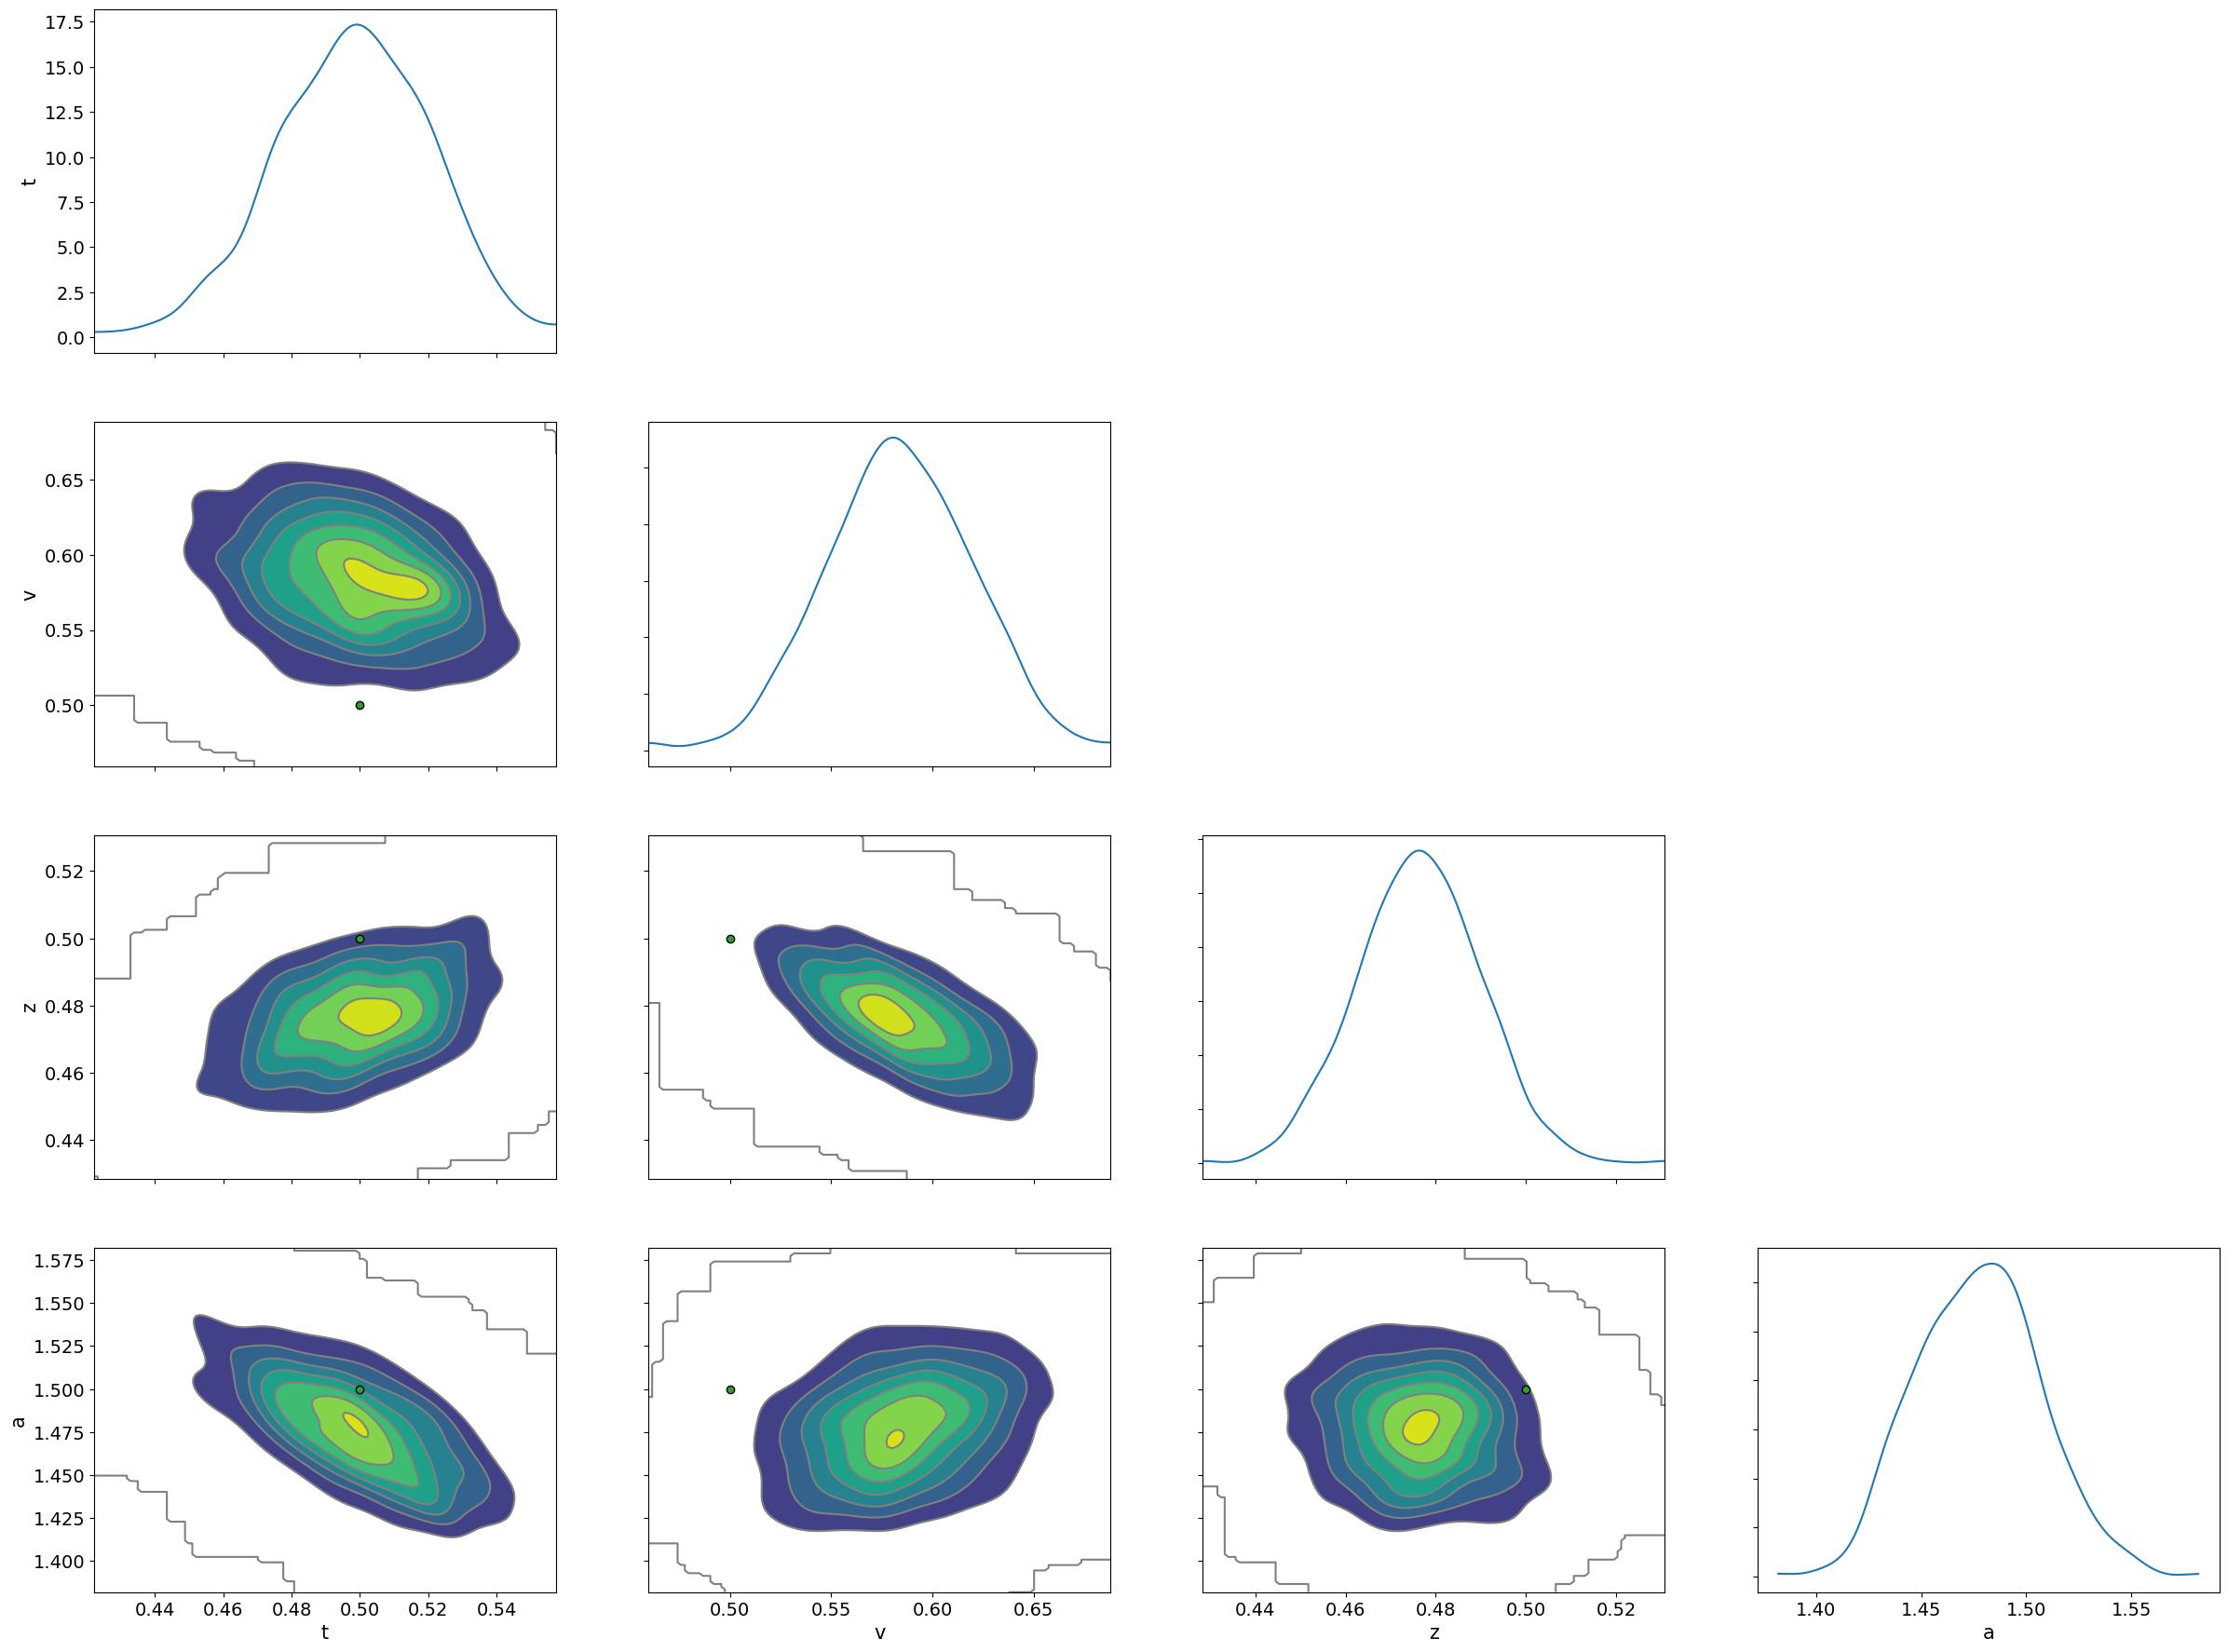

In [24]:
# ArViZ is ugly. Try plotting this in seaborn.


az.plot_pair(
    simple_ddm.traces,
    kind="kde",
    reference_values=true_params,
    marginals=True,
)


### Basic Hierarchical Model

In [ ]:
# Make some hierarchical data (need to make a wrapper and make this more sementic)
n_participants = 15  # number of participants
n_trials = 200  # number of trials per participant

sd_v = 0.5  # sd for v-intercept
mean_v = 0.5  # mean for v-intercept

data_list = []
for i in range(n_participants):
    # Make parameters for participant i
    v_intercept_i = RNG.normal(mean_v, sd_v, size=1)
    x = RNG.uniform(-1, 1, size=n_trials)
    v_x_i = 0.8
    y = RNG.uniform(-1, 1, size=n_trials)
    v_y_i = 0.3
    v_i = v_intercept_i + (v_x_i * x) + (v_y_i * y)

    a_i = 1.5
    t_i = 0.5
    z_i = 0.5

    # true_values = np.column_stack(
    #     [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=n_trials)]
    # )

    data_tmp = hssm.simulate_data(
        model="ddm", theta=dict(v=v_i, a=a_i, z=z_i, t=t_i), size=1
    )
    data_tmp["participant_id"] = i
    data_tmp["x"] = x
    data_tmp["y"] = y

    data_list.append(data_tmp)

In [29]:
# Make single dataframe out of participant-wise datasets
hierarchical_dataset = pd.concat(data_list)
hierarchical_dataset

,rt,response,participant_id,x,y
0,2.460405,1.0,0,0.675384,-0.799613
1,1.540837,1.0,0,0.122742,-0.816701
2,0.896385,1.0,0,-0.976926,0.941848
3,1.183957,1.0,0,0.264330,0.319143
4,0.918810,1.0,0,-0.195111,0.651900
...,...,...,...,...,...
195,1.828477,-1.0,14,-0.710609,0.922390
196,0.923095,1.0,14,0.380395,-0.452271
197,1.664551,1.0,14,0.286575,-0.425803
198,1.024383,1.0,14,-0.900106,0.282810


In [33]:
hierarchical_model = hssm.HSSM(
    data=hierarchical_dataset,
    model="ddm",
    noncentered=True,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 0.5,
                },
                "x": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
                "y": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
            },
            "formula": "v ~ 1 + (1|participant_id) + x + y",
            "link": "identity",
        }
    ],
)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


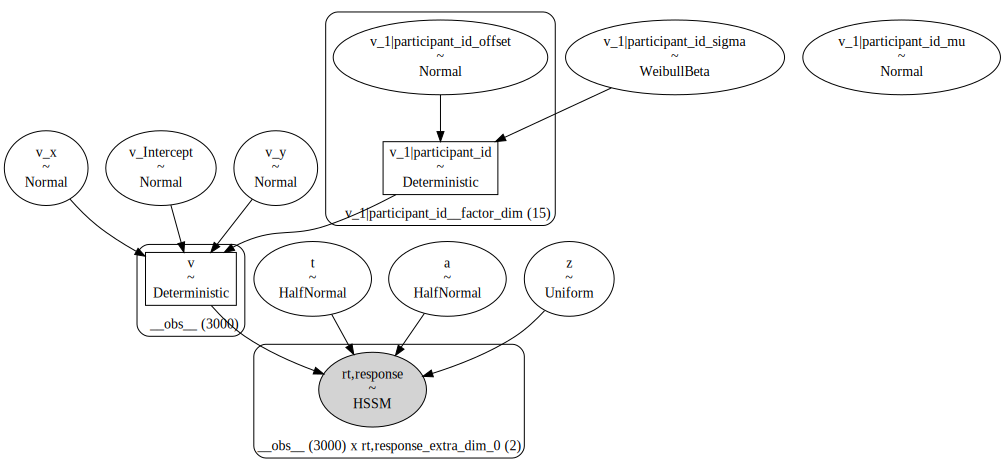

In [34]:
hierarchical_model.graph()

In [36]:
jax.config.update("jax_enable_x64", False)
hierarchical_samples = hierarchical_model.sample(
    sampler="mcmc",
    chains=2,
    cores=1,
    draws=500,
    tune=1000,
    mp_ctx="spawn",
)

Using default initvals. 

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [t, a, z, v_Intercept, v_x, v_y, v_1|participant_id_mu, v_1|participant_id_sigma, v_1|participant_id_offset]


c:\envs\hssm-meta\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2051 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\envs\hssm-meta\lib\site-packages\pymc\pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:03<00:00, 319.31it/s]


### Diagnostics

Sampling takes a while, so later.

In [37]:
az.summary(hierarchical_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_1|participant_id_offset[0],0.786,0.265,0.304,1.278,0.019,0.013,204.0,567.0,1.01
v_1|participant_id_offset[1],-1.475,0.352,-2.086,-0.808,0.022,0.016,251.0,488.0,1.00
v_1|participant_id_offset[2],1.517,0.331,0.944,2.162,0.023,0.016,213.0,363.0,1.01
v_1|participant_id_offset[3],1.377,0.323,0.783,1.927,0.022,0.015,221.0,353.0,1.00
v_1|participant_id_offset[4],1.146,0.301,0.572,1.661,0.020,0.014,236.0,529.0,1.01
v_1|participant_id_offset[5],0.815,0.271,0.350,1.371,0.018,0.013,222.0,429.0,1.01
v_1|participant_id_offset[6],-0.592,0.272,-1.089,-0.071,0.018,0.013,235.0,421.0,1.00
v_1|participant_id_offset[7],-0.614,0.272,-1.121,-0.120,0.018,0.012,242.0,463.0,1.00
v_1|participant_id_offset[8],-0.741,0.285,-1.235,-0.157,0.019,0.013,230.0,399.0,1.00
v_1|participant_id_offset[9],1.017,0.289,0.477,1.553,0.019,0.013,238.0,464.0,1.01


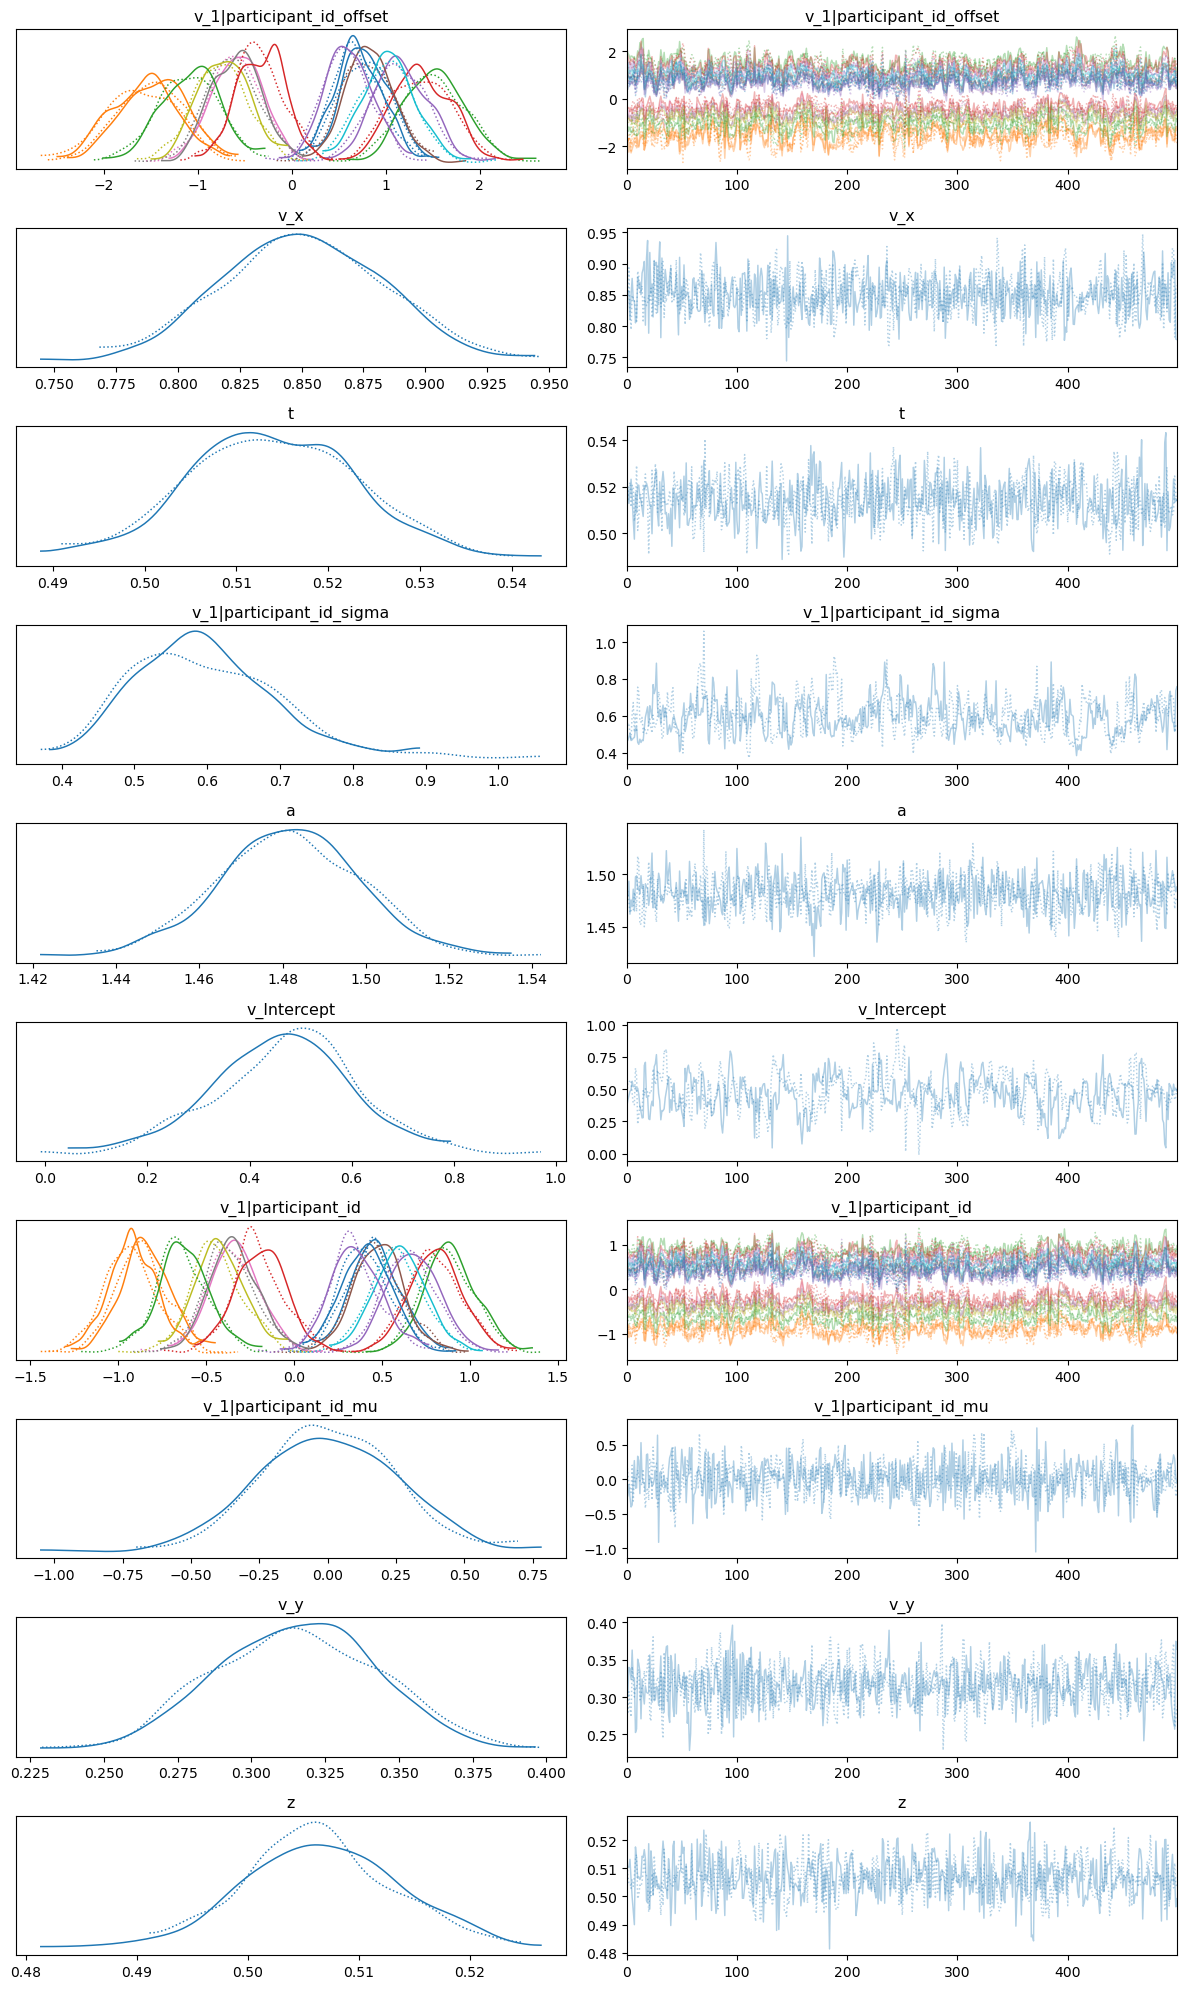

In [39]:
az.plot_trace(hierarchical_samples)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

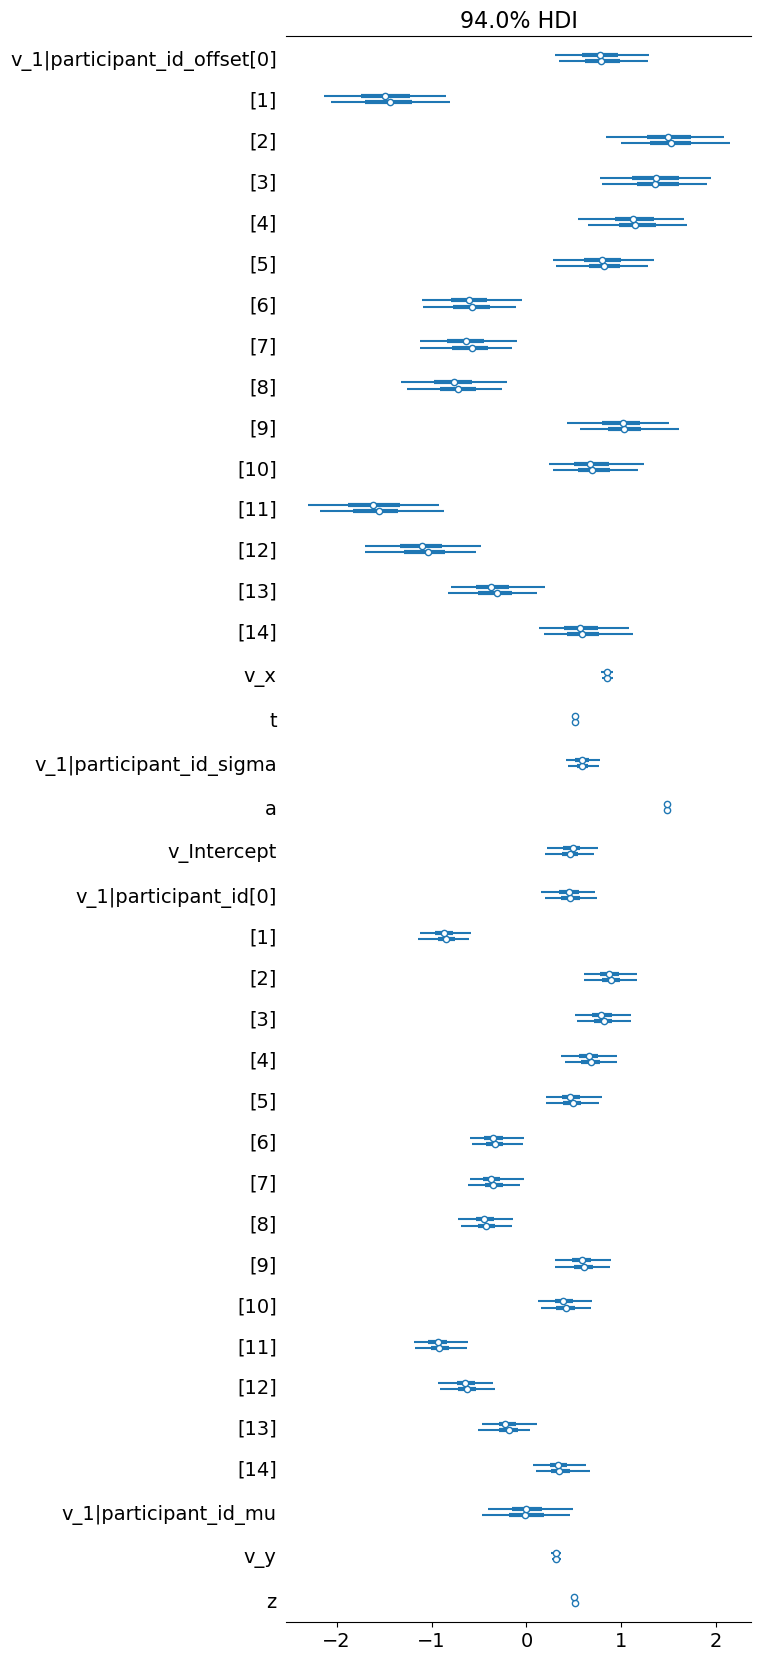

In [40]:
az.plot_forest(hierarchical_samples)

## Exercise: Modeling a DDM Variant with Collapsing Bounds

In some instances of perceptual decision-making (i.e., when an urgancy signal is present), we model the process as a DDM with **collapsing bounds** [(Hawkins et al., 2015)](https://www.jneurosci.org/content/35/6/2476.short). HSSM contains many supported model variants, and the collapsing bounds models are represented by an extra parameter $\theta$, which represents the slope of the bounds that collapse to the center.

In [46]:
collapsing_bounds_params = true_params
collapsing_bounds_params['angle'] = 0.1

In [47]:
# List all supported models in HSSM
collapsing_bounds_data = hssm.simulate_data(model="angle", theta=collapsing_bounds_params, size=1000)

In [48]:
collapsing_bounds_model = hssm.HSSM(data=collapsing_bounds_data, model="angle")

Model initialized successfully.


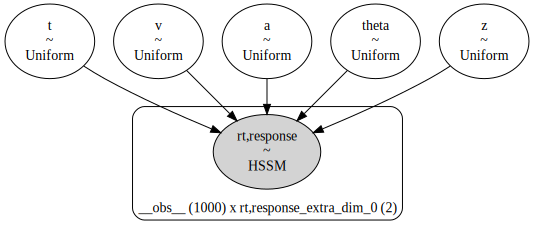

In [49]:
collapsing_bounds_model.graph()

In [50]:
jax.config.update("jax_enable_x64", False)
collapsing_bounds_samples = collapsing_bounds_model.sample(
    sampler="mcmc",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
    mp_ctx="spawn",
)

Using default initvals. 

Parallel sampling might not work with `jax` backend and the PyMC NUTS sampler on some platforms. Please consider using `nuts_numpyro` or `nuts_blackjax` sampler if that is a problem.


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t, a, theta, z, v]


c:\envs\hssm-meta\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 120 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [51]:
az.summary(collapsing_bounds_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.514,0.016,0.485,0.543,0.001,0.001,317.0,449.0,1.01
t,0.173,0.012,0.149,0.195,0.001,0.000,337.0,523.0,1.00
v,0.279,0.111,0.077,0.471,0.006,0.004,327.0,449.0,1.01
theta,1.177,0.004,1.169,1.185,0.000,0.000,326.0,555.0,1.00
a,2.984,0.016,2.952,3.000,0.001,0.001,401.0,222.0,1.01


array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

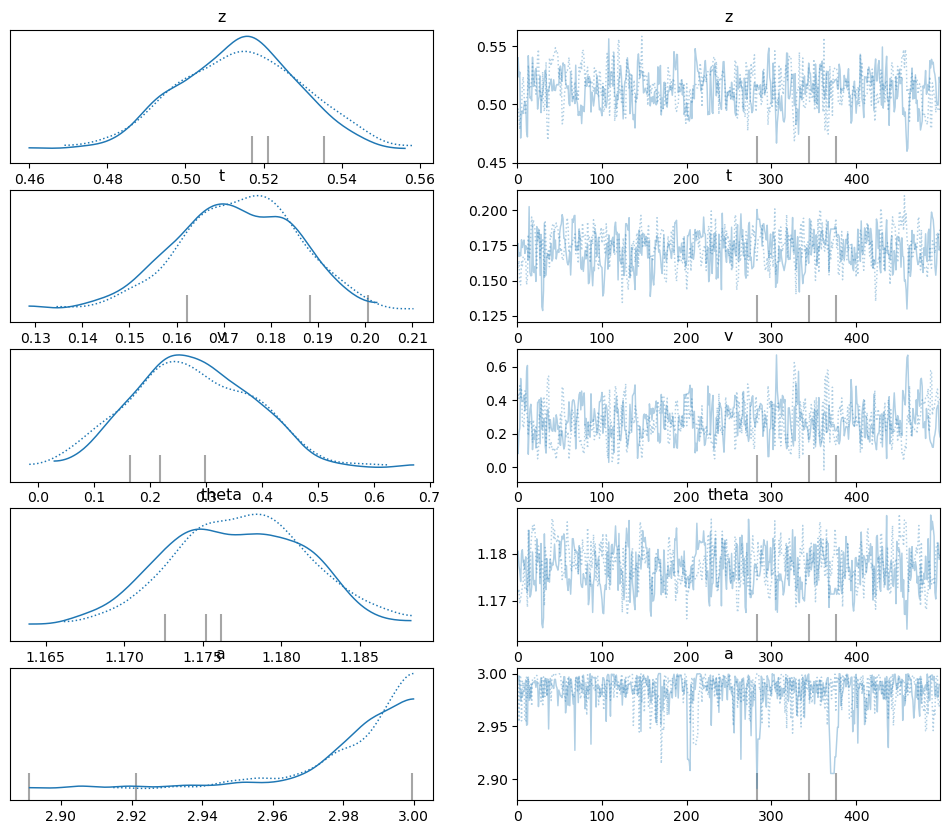

In [52]:
az.plot_trace(collapsing_bounds_samples)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

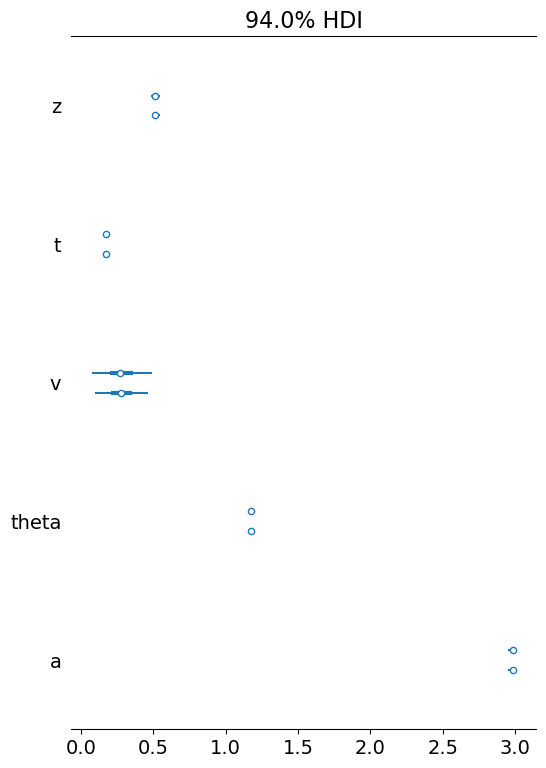

In [54]:
az.plot_forest(collapsing_bounds_samples)